In [1]:
import numpy as np
import os , sys
# sys.path.append("..")
# sys.path.append("../..")
# sys.path.append("../../..")

In [2]:
import sys,os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
sys.path.append(os.path.abspath("../../.."))
from src.diffusion_core.diffusion import GaussianDiffusion1D
from src.diffusion_core.model import Unet1D
import torch
import os,sys
# Add the parent directory of Gen_src to sys.path
import torch
import os

# Same architecture as in training
model = Unet1D(
    dim=32,
    dim_mults=(2, 4, 8, 16),
    channels=2,  # X and Y
    dropout=0.1
).cuda()  # or .to(device)

# Create the same diffusion wrapper
diffusion = GaussianDiffusion1D(
    model,
    seq_length=192,      # must match your training setup
    objective='pred_noise',
    timesteps=1000,
    auto_normalize=True
).cuda()  # or .to(device)

# Load checkpoint
checkpoint_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths_and_datas/dpp_0.1_autonorm_true_125_from_base_ddpm/model_epoch_124.pt"
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()
print("Loaded model weights from:", checkpoint_path)



/home/bardiya/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_core/diffusion.py:334: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


Loaded model weights from: /home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths_and_datas/dpp_0.1_autonorm_true_125_from_base_ddpm/model_epoch_124.pt


sampling loop time step: 100%|█████████▉| 999/1000 [00:15<00:00, 63.12it/s]


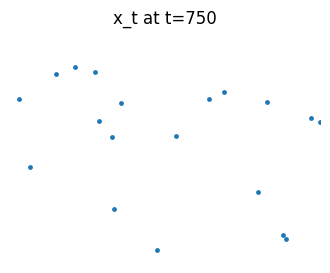

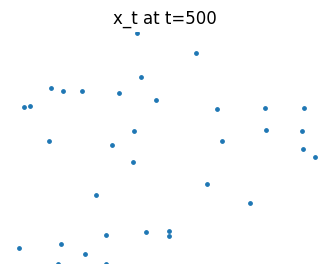

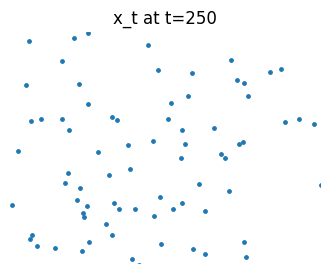

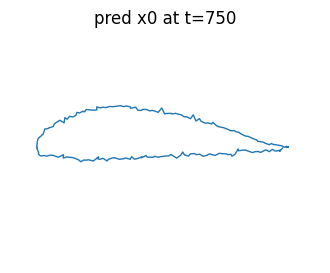

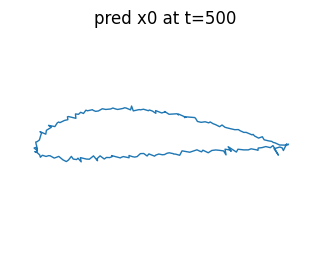

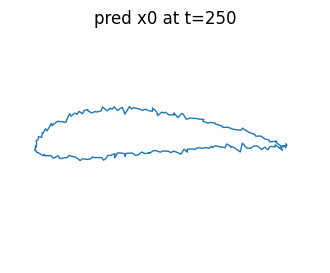

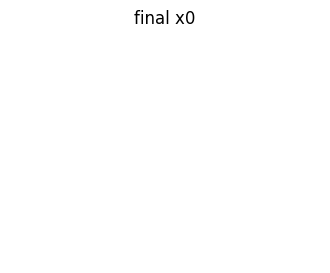

In [4]:

# --- 2) example usage (keep in your script) ------------------------------------------
import numpy as np
import torch
import matplotlib.pyplot as plt

# assume `diffusion` is your GaussianDiffusion1D, already with a trained model, on CUDA
B, C, N = 4, 2, 192                      # batch, channels, points
latent = torch.randn((B, C, N), device="cuda")

# get final sample and snapshots at t=750,500,250 (DDIM, deterministic)
final_img, snaps = diffusion.ddim_sample_with_snapshots(
    latent,
    timesteps_to_save=(750, 500, 250, 2),
    clip_denoised=True,
    ddim_sigma=0.0
)
# choose which sample in the batch to render
idx = 0

def plot_airfoil_tensor(sample_tensor, title=None, kind="line"):
    xy = sample_tensor.detach().cpu().numpy()  # (2, N)
    x, y = xy[0], xy[1]
    if kind == "line":
        plt.plot(x, y, linewidth=1)
    else:
        plt.scatter(x, y, s=6)
    if title: plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.25, 0.25)
    plt.gca().set_axis_off()

# --- make one figure per timestep for x_t (noisy state) ---
for t in [750, 500, 250]:
    plt.figure(figsize=(4, 3))                 # <-- new figure each time
    plot_airfoil_tensor(snaps[t]['x_t'][idx], title=f"x_t at t={t}", kind="scatter")
    # Optional: save each as its own file
    # plt.savefig(f"x_t_{t}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# --- make one figure per timestep for x0_pred (model's denoised prediction at that t) ---
for t in [750, 500, 250]:
    plt.figure(figsize=(4, 3))                 # <-- new figure each time
    plot_airfoil_tensor(snaps[t]['x0_pred'][idx], title=f"pred x0 at t={t}", kind="line")
    # Optional: save
    # plt.savefig(f"x0_pred_{t}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

# --- final fully denoised sample (optional, single image) ---
plt.figure(figsize=(4, 3))
plot_airfoil_tensor(final_img[idx], title="final x0", kind="line")
# plt.savefig("final_x0.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()


In [16]:
num_to_generate = 10000
batch_size      = 128

# generated_scaled = []
# latent = torch.randn((1,2,192)).to("cuda")
# samples1 = diffusion.latent_sample(latent , is_ddim=True)
# samples2 = diffusion.latent_sample(latent , is_ddim=True)
# generated_samples1 = inv_coords(samples1)
# generated_samples2 = inv_coords(samples2)


all_latent = []
all_shapes = []
with torch.no_grad():
    done = 0
    while done < num_to_generate:
        cur = min(batch_size, num_to_generate - done)
        
        latent = torch.randn((cur,2,192)).to("cuda")
        samples = diffusion.latent_sample(latent , is_ddim=True)
        generated_real = inv_coords(samples)
        
        all_latent.append(latent.cpu().detach().numpy())
        all_shapes.append(generated_real)
        done += cur
        print(f"Generated {done}/{num_to_generate}")

sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 77.17it/s]

Generated 2/2


In [17]:
# docker_mount_path = "/home/bardiya/projects/diffusion_air_manifolding/codes/Airfoil_MPI_system"
docker_mount_path = "/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/OpenFoam"
# docker_mount_path = "."

np.save(os.path.join(docker_mount_path , "DB2.npy") , {
    "latents": np.vstack(all_latent),
    "shapes": np.vstack(all_shapes),
    "performances": None
})

In [18]:
sys.path.append("../OpenFoam")
from OpenFoam.Airfoil_simulation_1.ShapeToPerformance import shape_to_performance as STP1
docker_container_id = "78257c051b5b" 

# command = fr"docker exec {docker_container_id} python3 /home/airfoil_UANA/performance_finding.py"
command = (
    f'docker exec {docker_container_id} bash -c "'
    f'source /opt/openfoam5/etc/bashrc && '
    f'cd /home/airfoil_UANA && '
    f'python3 performance_finding.py"'
)

os.system(command)


(2, 192, 2)
8


Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Could not find extruded vertex (0.9800665511016924, -0.004483645182613369, 1) in surface 1026
Error   : Unable to recover the edge 1885 (15/452) on GEdge 1000 (on GFace 1026)
Error   : ------------------------------
Error   : Mesh generation error summary
Error   :    43 warnings
Error   :     8 errors
Error   : Check the full log for details
Error   : -----------

core 1:
sample 1:
	Using len 40.000 angle +0.000 
	Resulting freestream vel x,y: 40.0,-0.0
error during mesh creation!
	mesh generation failed, aborting
-1000
1000
/home/airfoil_UANA
/home/airfoil_UANA
core 0:
sample 0:
	Using len 40.000 angle +0.000 
	Resulting freestream vel x,y: 40.0,-0.0
/home/airfoil_UANA/Airfoil_simulation_1/OpenFOAM_0
/home/airfoil_UANA/Airfoil_simulation_1/OpenFOAM_0
0.2474784
0.008937957
0.txt
1.txt
[0 1]
[[ 2.47478e-01  8.93800e-03  0.00000e+00]
 [-1.00000e+03  1.00000e+03  1.00000e+00]]
done!!!


0

In [19]:
performance_path =os.path.join(docker_mount_path , rf"performance.npy")
perfromance = np.load(performance_path,allow_pickle=True)
perfromance

array([[ 2.47478e-01,  8.93800e-03,  0.00000e+00],
       [-1.00000e+03,  1.00000e+03,  1.00000e+00]])